In [1]:
from matplotlib import style
style.use('fivethirtyeight')

#dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime

#ORM
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, text, func




# Reflect Tables into SQLAlchemy ORM

In [2]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [3]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within the 'dow' table and its types
for table in tables:
    print(table)
    print("--------")
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()


# returns 2 tables: measurement and station

measurement
--------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
--------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [4]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [5]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
station = Base.classes.station
measurement = Base.classes.measurement

In [6]:
# Create a session
session = Session(engine)

In [8]:
#check out station metadata with rawSQL
query = text("""SELECT * from station LIMIT 10""")
df = pd.read_sql(query, con=conn)
df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [9]:
#check out measurement data w/ raw SQL, tobs = temp observation station AND date are both ref to observed data b/c of multiple obs by stations
query = text("""SELECT * from measurement LIMIT 10""")
df = pd.read_sql(query, con=conn)
df

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
5,6,USC00519397,2010-01-07,0.06,70.0
6,7,USC00519397,2010-01-08,0.00,64.0
7,8,USC00519397,2010-01-09,0.00,68.0
8,9,USC00519397,2010-01-10,0.00,73.0
9,10,USC00519397,2010-01-11,0.01,64.0


# Exploratory Precipitation Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
session.query(func.max(measurement.date)).all()

[('2017-08-23',)]

In [31]:



# Perform a query to retrieve the data and precipitation scores


# Save the query results as a Pandas DataFrame. Explicitly set the column names


# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data

rows = session.query(measurement.id, measurement.station, measurement.date, measurement.prcp).filter(measurement.date >= '2016-08-23').order_by(measurement.date).all()
df2016prcp = pd.DataFrame(rows)
df2016prcp.head()

,id,station,date,prcp
0,2364,USC00519397,2016-08-23,0.00
1,5091,USC00513117,2016-08-23,0.15
2,7331,USC00514830,2016-08-23,0.05
3,8825,USC00517948,2016-08-23,NaN
4,11851,USC00519523,2016-08-23,0.02


<Figure size 1000x600 with 0 Axes>

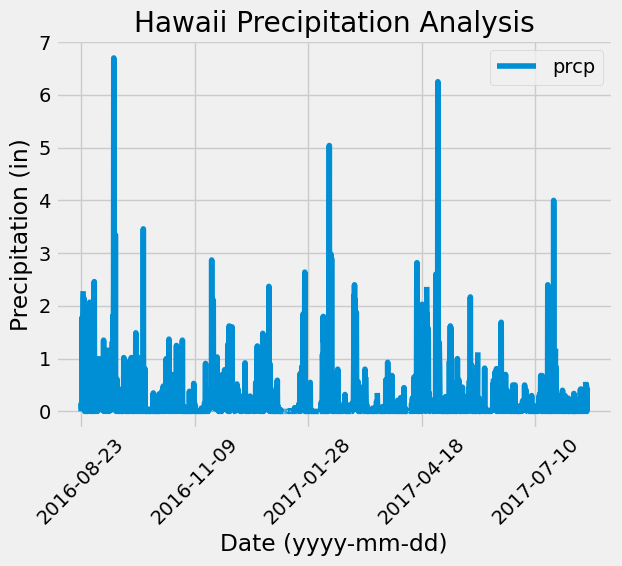

In [43]:
# Make plot
plt.figure(figsize=(10, 6))
df2016prcp.plot(x="date", y="prcp")
plt.title("Hawaii Precipitation Analysis")
plt.ylabel("Precipitation (in)")
plt.xlabel("Date (yyyy-mm-dd)")
plt.xticks(rotation=45)
plt.show()

In [44]:
# Use Pandas to calculate the summary statistics for the precipitation data
df2016prcp.prcp.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [46]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.station)).all()

[(9,)]

In [53]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
#count all the station observations and put output in new column called num_obs
#group by station
#order by descending count
rows = session.query(measurement.station,func.count(measurement.id).label('num_obs')).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
maxrows = pd.DataFrame(rows)
maxrows.head()

,station,num_obs
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [54]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [58]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281 = session.query(measurement.id, measurement.station, measurement.date, measurement.tobs).filter(measurement.station =='USC00519281').filter(measurement.date >= '2016-08-23').order_by(measurement.date).all()
last12mo = pd.DataFrame(USC00519281)
last12mo.head()

,id,station,date,tobs
0,14608,USC00519281,2016-08-23,77.0
1,14609,USC00519281,2016-08-24,77.0
2,14610,USC00519281,2016-08-25,80.0
3,14611,USC00519281,2016-08-26,80.0
4,14612,USC00519281,2016-08-27,75.0


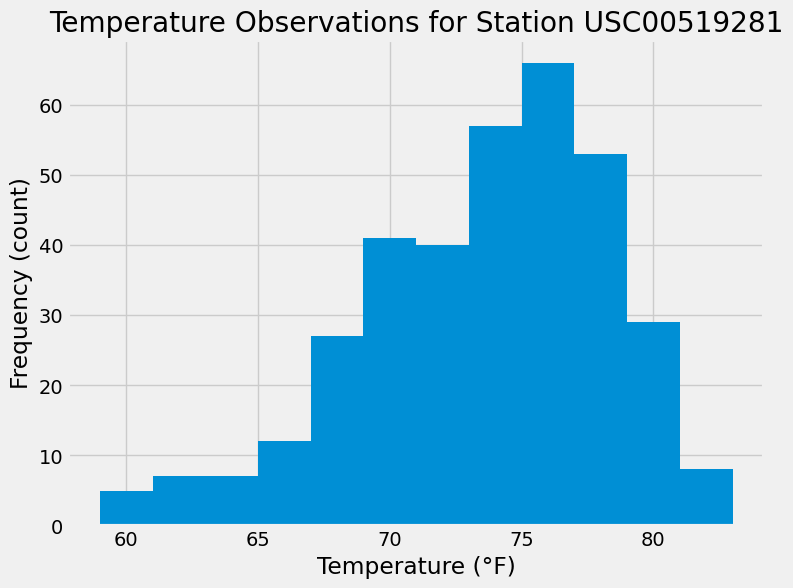

In [64]:
#plot
plt.figure(figsize=(8, 6))
plt.hist(last12mo.tobs, bins=12)
# df1.plot(x="date", y="prcp")
plt.title("Temperature Observations for Station USC00519281")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency (count)")
plt.show()

# Close Session

In [65]:
# Close Session
session.close()